In [ ]:
# default_exp data.metadatasets

# Metadatasets: a dataset of datasets

> This functionality will allow you to create a dataset from data stores in multiple, smaller datasets.

* I'd like to thank both Thomas Capelle (https://github.com/tcapelle)  and Xander Dunn (https://github.com/xanderdunn) for their contributions to make this code possible. 
* This functionality allows you to use multiple numpy arrays instead of a single one, which may be very useful in many practical settings. I've tested it with 10k+ datasets and it works well. 

In [ ]:
#export
from tsai.imports import *
from tsai.utils import *
from tsai.data.validation import *
from tsai.data.core import *

In [ ]:
#export
class TSMetaDataset():
    " A dataset capable of indexing mutiple datasets at the same time"
    def __init__(self, dataset_list, **kwargs):
        if not is_listy(dataset_list): dataset_list = [dataset_list]
        self.datasets = dataset_list
        self.split = kwargs['split'] if 'split' in kwargs else None            
        self.mapping = self._mapping()
        if hasattr(dataset_list[0], 'loss_func'): 
            self.loss_func =  dataset_list[0].loss_func
        else: 
            self.loss_func = None

    def __len__(self):
        if self.split is not None: 
            return len(self.split)
        else:
            return sum([len(ds) for ds in self.datasets])

    def __getitem__(self, idx):
        if self.split is not None: idx = self.split[idx]
        idx = listify(idx)
        idxs = self.mapping[idx]
        idxs = idxs[idxs[:, 0].argsort()]
        self.mapping_idxs = idxs
        ds = np.unique(idxs[:, 0])
        b = [self.datasets[d][idxs[idxs[:, 0] == d, 1]] for d in ds]
        output = tuple(map(torch.cat, zip(*b)))
        return output

    def _mapping(self):
        lengths = [len(ds) for ds in self.datasets]
        idx_pairs = np.zeros((np.sum(lengths), 2)).astype(np.int32)
        start = 0
        for i,length in enumerate(lengths):
            if i > 0: 
                idx_pairs[start:start+length, 0] = i
            idx_pairs[start:start+length, 1] = np.arange(length)
            start += length
        return idx_pairs
    
    @property
    def vars(self):
        s = self.datasets[0][0][0] if not isinstance(self.datasets[0][0][0], tuple) else self.datasets[0][0][0][0]
        return s.shape[-2]
    @property
    def len(self): 
        s = self.datasets[0][0][0] if not isinstance(self.datasets[0][0][0], tuple) else self.datasets[0][0][0][0]
        return s.shape[-1]


class TSMetaDatasets(FilteredBase):
    def __init__(self, metadataset, splits):
        store_attr()
        self.mapping = metadataset.mapping
    def subset(self, i):
        return type(self.metadataset)(self.metadataset.datasets, split=self.splits[i])
    @property
    def train(self): 
        return self.subset(0)
    @property
    def valid(self): 
        return self.subset(1)

Let's create 3 datasets. In this case they will have different sizes.

In [ ]:
vocab = L(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j'])
dsets = []
for i in range(3):
    size = np.random.randint(50, 150)
    X = torch.rand(size, 5, 50)
    y = vocab[torch.randint(0, 10, (size,))]
    tfms = [None, TSClassification()]
    dset = TSDatasets(X, y, tfms=tfms)
    dsets.append(dset)
dsets

[(#96) [(tensor([[2.7282e-01, 3.4553e-01, 7.2020e-01, 2.3727e-01, 7.2726e-01, 7.3839e-01,
          9.1268e-01, 7.0684e-01, 8.2316e-01, 5.2028e-01, 7.9140e-01, 9.5113e-01,
          7.9168e-01, 3.8275e-01, 9.9042e-02, 6.9085e-02, 4.4092e-01, 7.1495e-01,
          3.7378e-01, 8.9580e-01, 4.7406e-01, 6.3088e-01, 5.4409e-01, 8.3754e-01,
          1.8083e-01, 5.5559e-01, 3.9524e-01, 7.1273e-01, 2.2518e-01, 6.0989e-01,
          1.9509e-01, 7.3187e-01, 5.9500e-01, 5.2621e-01, 7.2850e-01, 9.3011e-01,
          5.5469e-01, 3.3911e-01, 6.0465e-01, 4.1305e-01, 2.0127e-01, 2.0552e-01,
          4.1410e-01, 3.7885e-01, 9.4917e-01, 1.5653e-01, 4.1755e-01, 7.8075e-01,
          7.3644e-01, 8.8298e-01],
         [1.5283e-01, 8.6502e-01, 2.9876e-01, 4.0544e-01, 2.0909e-01, 9.6211e-01,
          5.7076e-01, 2.3068e-01, 4.6773e-01, 9.0560e-01, 3.3372e-01, 9.1594e-01,
          4.2686e-01, 5.9567e-02, 5.7666e-01, 6.9768e-01, 2.6179e-01, 4.2413e-02,
          9.9398e-02, 2.4024e-01, 8.3148e-05, 2.0488e-0

In [ ]:
metadataset = TSMetaDataset(dsets)
metadataset, metadataset.vars, metadataset.len

(<__main__.TSMetaDataset at 0x7fc0ea0bfb70>, 5, 50)

We'll apply splits now to create train and valid metadatasets: 

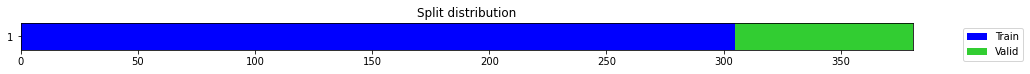

((#305) [0,1,2,3,4,5,6,7,8,9...],
 (#76) [305,306,307,308,309,310,311,312,313,314...])

In [ ]:
splits = TimeSplitter()(metadataset)
splits

In [ ]:
metadatasets = TSMetaDatasets(metadataset, splits=splits)
metadatasets.train, metadatasets.valid

(<__main__.TSMetaDataset at 0x7fc0ea0bf940>,
 <__main__.TSMetaDataset at 0x7fc0ea0bf550>)

In [ ]:
dls = TSDataLoaders.from_dsets(metadatasets.train, metadatasets.valid)
xb, yb = first(dls.train)
xb, yb

(tensor([[[0.6842, 0.5728, 0.4139,  ..., 0.1322, 0.6641, 0.7807],
          [0.5041, 0.9936, 0.8412,  ..., 0.1569, 0.3971, 0.3009],
          [0.3586, 0.3576, 0.4791,  ..., 0.5208, 0.9518, 0.0294],
          [0.6222, 0.3178, 0.3313,  ..., 0.9162, 0.7928, 0.2579],
          [0.9389, 0.2747, 0.2150,  ..., 0.5623, 0.2970, 0.6708]],
 
         [[0.2012, 0.1050, 0.0631,  ..., 0.4680, 0.5874, 0.5435],
          [0.9745, 0.1858, 0.3427,  ..., 0.5963, 0.2462, 0.3543],
          [0.6028, 0.7218, 0.7033,  ..., 0.9981, 0.2168, 0.8180],
          [0.4008, 0.4344, 0.4087,  ..., 0.2953, 0.1971, 0.0933],
          [0.1932, 0.6562, 0.0189,  ..., 0.5652, 0.2082, 0.9164]],
 
         [[0.2442, 0.7152, 0.0710,  ..., 0.8941, 0.1119, 0.7261],
          [0.5678, 0.3810, 0.3175,  ..., 0.2772, 0.3125, 0.8684],
          [0.5888, 0.3438, 0.7345,  ..., 0.0015, 0.3619, 0.0286],
          [0.3178, 0.7590, 0.5820,  ..., 0.1992, 0.6964, 0.3243],
          [0.8020, 0.5816, 0.8646,  ..., 0.4093, 0.5283, 0.0626]],
 
 

There also en easy way to map any particular sample in a batch to the original dataset and id: 

In [ ]:
dls = TSDataLoaders.from_dsets(metadatasets.train, metadatasets.valid)
xb, yb = first(dls.train)
mappings = dls.train.dataset.mapping_idxs
for i, (xbi, ybi) in enumerate(zip(xb, yb)):
    ds, idx = mappings[i]
    test_close(dsets[ds][idx][0].data.cpu(), xbi.cpu())
    test_close(dsets[ds][idx][1].data.cpu(), ybi.cpu())

For example the 3rd sample in this batch would be: 

In [ ]:
dls.train.dataset.mapping_idxs[2]

array([ 0, 78], dtype=int32)

In [ ]:
#hide
out = create_scripts(); beep(out)